# DECISION TREE (DIY)

In [1]:
import sklearn
import pandas as pd 
from pprint import pprint
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [2]:
def entropy(target_col):  
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

def InfoGain(data,split_attribute_name,target_name="class"):       
    total_entropy = entropy(data[target_name]) 
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
     
    #print("vals, counts, entropy:", vals, ",", counts, ",",Weighted_Entropy )
    #Calculate the information_gain
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain

def SplitInfo(data, col):
    elements, counts = np.unique(data[col], return_counts = True)
    splitInfo = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return splitInfo

def GainRatio(data, col):
    return InfoGain(data, col)/SplitInfo(data, col)
    
def prunning(data, features):
    return [i for i in features if len(np.unique(data[i])) != 1]

def C45(data, originaldata, features, depth = 0, max_depth=5, target_name = "class", parent_node = None):
    if(parent_node!=None and len(np.unique(data[parent_node]))==1):
        features = prunning(data,features)
    if(len(np.unique(data[target_name])) <= 1):
        return np.unique(data[target_name])[0]
    #xóa root
    else:   
        #lấy node có số phần tử cao nhất
        parent_node_class = np.unique(data[target_name])[np.argmax(np.unique(data[target_name],return_counts=True)[1])]
        #tính ig
        item_values = [GainRatio(data, feature) for feature in features]
        #tìm index entropy cao nhất
        best_attribute_idx = np.argmax(item_values)
        
        parent_node = features[best_attribute_idx]
        tree = {parent_node:{}}
        #bỏ parent node
        features = [i for i in features if i != parent_node]
        #subtree
        for val in np.unique(data[parent_node]):
            val = val
            subdata = data.where(data[parent_node] == val).dropna()
            subtree = C45(subdata, data, features, depth, max_depth, target_name, parent_node)
            tree[parent_node][val] = subtree
        return tree
    
        
def train_test_split(dataset):
    training_data = dataset.iloc[:80].reset_index(drop=True)
    testing_data = dataset.iloc[80:].reset_index(drop=True)
    return training_data,testing_data

def predict(query,tree,default = 1):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]] 
            except:
                return default
            result = tree[key][query[key]]           
            if isinstance(result,dict):
                return predict(query,result)
            else:
                return result
            
def test(data,tree):    
    queries = data.iloc[:,:-1].to_dict(orient = "records")
    predicted = pd.DataFrame(columns=["predicted"])
    for i in range(len(data)):
        predicted.loc[i,"predicted"] = predict(queries[i],tree,1.0)
    print('implement: ',(np.sum(predicted["predicted"] == data["class"])/len(data))*100,'%')

In [3]:
dataAni = pd.read_csv("Animal.csv")

training_data = train_test_split(dataAni)[0]
testing_data = train_test_split(dataAni)[1]

# cây quyết định (100% dataset)

In [4]:
main_tree = C45(dataAni, dataAni, dataAni.columns[:-1])
pprint(main_tree)
test(testing_data, main_tree)

{'milk': {0: {'fins': {0.0: {'feathers': {0.0: {'backbone': {0.0: {'airborne': {0.0: {'predator': {0.0: {'legs': {0.0: 7.0,
                                                                                                                  6.0: 6.0}},
                                                                                                   1.0: 7.0}},
                                                                                1.0: 6.0}},
                                                             1.0: {'tail': {0.0: 5.0,
                                                                            1.0: {'aquatic': {0.0: 3.0,
                                                                                              1.0: {'eggs': {0.0: 3.0,
                                                                                                             1.0: 5.0}}}}}}}},
                                          1.0: 2.0}},
                       1.0: 4.0}},
          1: 1.0}}
imp

# cây quyết định (70% dataset)

In [5]:
#sau khi pruning
tree_C45 = C45(training_data,training_data,training_data.columns[:-1])
pprint(tree_C45)
test(testing_data,tree_C45)

{'feathers': {0: {'backbone': {0.0: {'airborne': {0.0: {'predator': {0.0: 6.0,
                                                                     1.0: 7.0}},
                                                  1.0: 6.0}},
                               1.0: {'milk': {0.0: {'fins': {0.0: {'legs': {0.0: 3.0,
                                                                            4.0: 5.0}},
                                                             1.0: 4.0}},
                                              1.0: 1.0}}}},
              1: 2.0}}
implement:  80.95238095238095 %


# So sánh với Scikit-learn

In [6]:
sklearn.tree.DecisionTreeClassifier(criterion='entropy')

train_features = dataAni.iloc[:80,:-1]
test_features = dataAni.iloc[80:,:-1]
train_targets = dataAni.iloc[:80,-1]
test_targets = dataAni.iloc[80:,-1]

clf = tree.DecisionTreeClassifier(max_depth=5)
#max_depth = 5 là độ sâu của cây quyết định
#Khi max_depth = 4 Cây không thể hiện đủ 7 class 
clf = clf.fit(train_features, train_targets)
f_name = list(train_features.columns)
print(tree.plot_tree(clf, feature_names = f_name,
class_names = ["1:Mammal","2:Bird","3:Reptile","4:Fish","5:Amphibian","6:Bug","7:Invertebrate"], filled = True))

[Text(354.28571428571433, 338.79999999999995, 'milk <= 0.5\ngini = 0.727\nsamples = 80\nvalue = [36, 16, 2, 10, 3, 6, 7]\nclass = 1:Mammal'), Text(283.42857142857144, 277.2, 'feathers <= 0.5\ngini = 0.765\nsamples = 44\nvalue = [0, 16, 2, 10, 3, 6, 7]\nclass = 2:Bird'), Text(212.57142857142858, 215.59999999999997, 'fins <= 0.5\ngini = 0.747\nsamples = 28\nvalue = [0, 0, 2, 10, 3, 6, 7]\nclass = 4:Fish'), Text(141.71428571428572, 154.0, 'predator <= 0.5\ngini = 0.698\nsamples = 18\nvalue = [0, 0, 2, 0, 3, 6, 7]\nclass = 7:Invertebrate'), Text(70.85714285714286, 92.39999999999998, 'gini = 0.0\nsamples = 5\nvalue = [0, 0, 0, 0, 0, 5, 0]\nclass = 6:Bug'), Text(212.57142857142858, 92.39999999999998, 'toothed <= 0.5\ngini = 0.627\nsamples = 13\nvalue = [0, 0, 2, 0, 3, 1, 7]\nclass = 7:Invertebrate'), Text(141.71428571428572, 30.80000000000001, 'gini = 0.219\nsamples = 8\nvalue = [0, 0, 0, 0, 0, 1, 7]\nclass = 7:Invertebrate'), Text(283.42857142857144, 30.80000000000001, 'gini = 0.48\nsamples

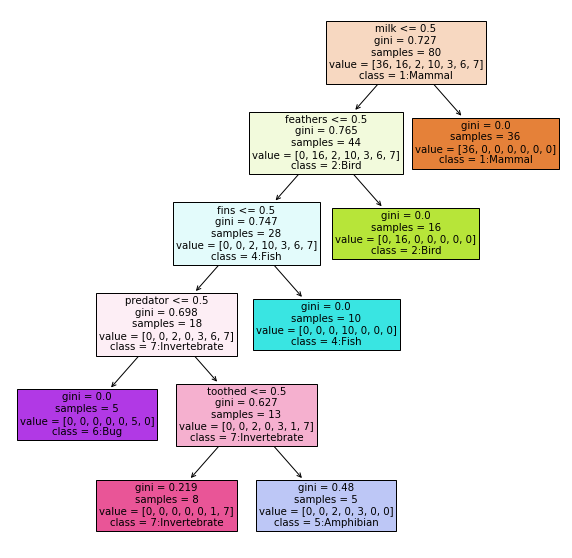

In [7]:
#in cây quyết định của bảng data_Ani_fea
from sklearn import tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
_=tree.plot_tree(clf, feature_names=f_name,
                 class_names = ["1:Mammal","2:Bird","3:Reptile","4:Fish","5:Amphibian","6:Bug","7:Invertebrate"],
                   filled = True)

In [8]:
predicted = clf.predict(test_features)
print(predicted)
print ("Tỷ lệ dự đoán:",sum(predicted==test_targets)/float(len(test_targets))*100)


[5 6 4 2 1 7 4 2 6 6 6 5 4 1 1 2 1 6 1 6 2]
Tỷ lệ dự đoán: 71.42857142857143
